In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 695 (delta 36), reused 0 (delta 0), pack-reused 618
Receiving objects: 100% (695/695), 29.76 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=ef8ebc803eee655bbb8bcc07bab927c63fc3ab87fab3e03e27a132ba9f7ad3cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-zmxlqvdo/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [2]:
from deepflows.RFN.data_generators import celeba
from deepflows.RFN import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.RFN.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
from deepflows.RFN.utils import *
from deepflows.RFN.data_generators import stochasticMovingMnist
import matplotlib.patches as patches
import torchvision
from torch.autograd import Variable

device = utils.set_gpu(True)

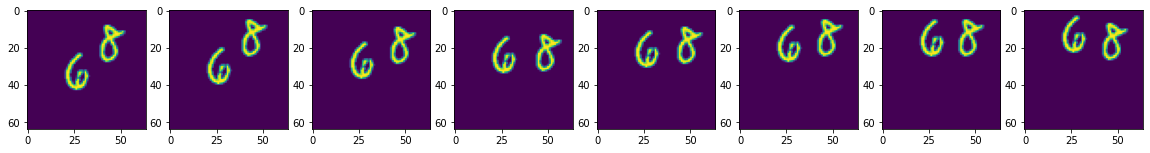

In [3]:
batch_size = 64
data_set_type = "mnist"
three_channels=False


n_frames = 8
testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=64, digit_size=28, num_digits=2, 
                                            deterministic=False, three_channels=three_channels, step_length=4, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=64, digit_size=28, num_digits=2, 
                                              deterministic=False, three_channels=three_channels, step_length=4, normalize=False)

train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
x_plot = next(iter(train_loader))[0].permute(0,2,3,1)


fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
for i in range(n_frames): 
  ax[i].imshow(x_plot[i].view(64, 64))
plt.show()

In [4]:


class vgg_layer(nn.Module):
    def __init__(self, nin, nout):
        super(vgg_layer, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(nin, nout, 3, 1, 1),
                nn.BatchNorm2d(nout),
                nn.LeakyReLU(0.2, inplace=True)
                )

    def forward(self, input):
        return self.main(input)

class Encoder(nn.Module):
    def __init__(self, dim, nc=1):
        super(Encoder, self).__init__()
        self.dim = dim
        # 64 x 64
        self.c0 = nn.Sequential(
                vgg_layer(nc, 32),
                vgg_layer(32, 32),
                )
        self.c1 = nn.Sequential(
                vgg_layer(32, 64),
                vgg_layer(64, 64),
                )
        # 32 x 32
        self.c2 = nn.Sequential(
                vgg_layer(64, 128),
                vgg_layer(128, 128),
                )
        # 16 x 16 
        self.c3 = nn.Sequential(
                vgg_layer(128, 256),
                vgg_layer(256, 256),
                vgg_layer(256, 256),
                )
        # 8 x 8
        self.c4 = nn.Sequential(
                vgg_layer(256, 512),
                vgg_layer(512, 512),
                vgg_layer(512, 512),
                )
        # 4 x 4
        self.c5 = nn.Sequential(
                nn.Conv2d(512, dim, 2, 1, 0),
                nn.BatchNorm2d(dim),
                nn.Tanh()
                )
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, input):
        h0 = self.c0(input) # 64x64
        h1 = self.c1(self.mp(h0)) # 32x32
        h2 = self.c2(self.mp(h1)) # 16x16
        h3 = self.c3(self.mp(h2)) # 8x8
        h4 = self.c4(self.mp(h3)) # 4x4
        h5 = self.c5(self.mp(h4)) # 1x1
        return h5.view(-1, self.dim), [h0, h1, h2, h3, h4]


class Decoder(nn.Module):
    def __init__(self, dim, nc=1):
        super(Decoder, self).__init__()
        self.dim = dim
        # 1 x 1 -> 4 x 4
        self.upc1 = nn.Sequential(
                nn.ConvTranspose2d(dim, 512, 2, 1, 0),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True)
                )
        # 8 x 8
        self.upc2 = nn.Sequential(
                vgg_layer(512*2, 512),
                vgg_layer(512, 512),
                vgg_layer(512, 256)
                )
        # 16 x 16
        self.upc3 = nn.Sequential(
                vgg_layer(256*2, 256),
                vgg_layer(256, 256),
                vgg_layer(256, 128)
                )
        # 32 x 32
        self.upc4 = nn.Sequential(
                vgg_layer(128*2, 128),
                vgg_layer(128, 64)
                )
        self.upc5 = nn.Sequential(
                vgg_layer(64*2, 64),
                vgg_layer(64, 32)
                )
        self.out = nn.Sequential(
                vgg_layer(32*2, 32),
                nn.ConvTranspose2d(32, nc, 3, 1, 1),
                nn.Sigmoid()
                )
        
        self.up = nn.UpsamplingNearest2d(scale_factor=2)

    def forward(self, input):
        vec, skip = input 
        d1 = self.upc1(vec.view(-1, self.dim, 1, 1)) # 1 -> 2
        up1 = self.up(d1) # 2 -> 4
        d2 = self.upc2(torch.cat([up1, skip[4]], 1)) # 4 x 4
        up2 = self.up(d2) # 4 -> 8 
        d3 = self.upc3(torch.cat([up2, skip[3]], 1)) # 8 x 8 
        up3 = self.up(d3) # 8 -> 16 
        d4 = self.upc4(torch.cat([up3, skip[2]], 1)) # 16 x 16
        up4 = self.up(d4) # 16 -> 32
        d5 = self.upc5(torch.cat([up4, skip[1]], 1)) # 32 x 32
        up5 = self.up(d5) # 32 -> 64
        output = self.out(torch.cat([up5, skip[0]], 1)) # 64 x 64
        return output #[d1, d2, d3, d4, d5]

In [5]:
class lstm_svg(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, batch_size):
        super(lstm_svg, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.embed = nn.Linear(input_size, hidden_size)
        self.lstm = nn.ModuleList([nn.LSTMCell(hidden_size, hidden_size) for i in range(self.n_layers)])
        self.output = nn.Sequential(
                nn.Linear(hidden_size, output_size),
                #nn.BatchNorm1d(output_size),
                nn.Tanh())
        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(self.batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(self.batch_size, self.hidden_size).cuda())))
        return hidden

    def forward(self, input):
        embedded = self.embed(input.view(-1, self.input_size))
        h_in = embedded
        for i in range(self.n_layers):
            self.hidden[i] = self.lstm[i](h_in, self.hidden[i])
            h_in = self.hidden[i][0]

        return self.output(h_in)

class gaussian_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, batch_size):
        super(gaussian_lstm, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.embed = nn.Linear(input_size, hidden_size)
        self.lstm = nn.ModuleList([nn.LSTMCell(hidden_size, hidden_size) for i in range(self.n_layers)])
        self.mu_net = nn.Linear(hidden_size, output_size)
        self.logvar_net = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = []
        for i in range(self.n_layers):
            hidden.append((Variable(torch.zeros(self.batch_size, self.hidden_size).cuda()),
                           Variable(torch.zeros(self.batch_size, self.hidden_size).cuda())))
        return hidden

    def reparameterize(self, mu, logvar):
        logvar = logvar.mul(0.5).exp_()
        eps = Variable(logvar.data.new(logvar.size()).normal_())
        return eps.mul(logvar).add_(mu)

    def forward(self, input):
        embedded = self.embed(input.view(-1, self.input_size))
        h_in = embedded
        for i in range(self.n_layers):
            self.hidden[i] = self.lstm[i](h_in, self.hidden[i])
            h_in = self.hidden[i][0]
        mu = self.mu_net(h_in)
        logvar = self.logvar_net(h_in)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

# Train

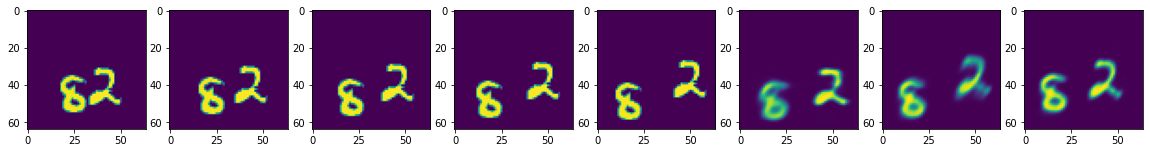

[06] mse loss: 0.00300 | kld loss: 0.83346 (691200)


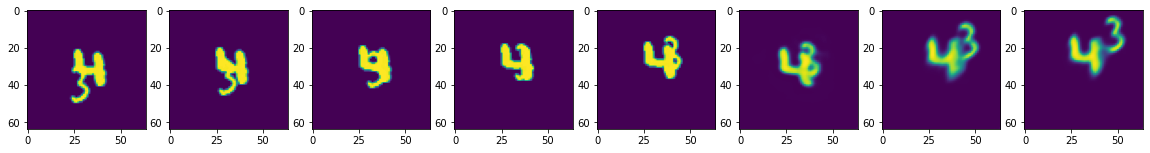

[06] mse loss: 0.00356 | kld loss: 1.00533 (691200)


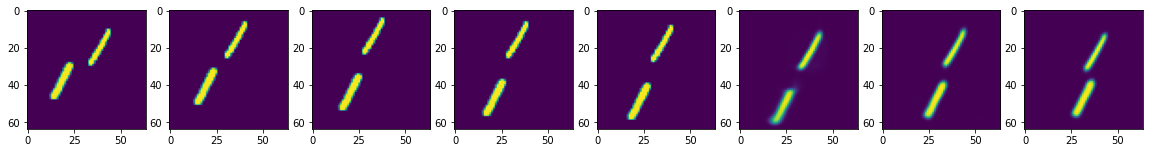

[06] mse loss: 0.00412 | kld loss: 1.17208 (691200)


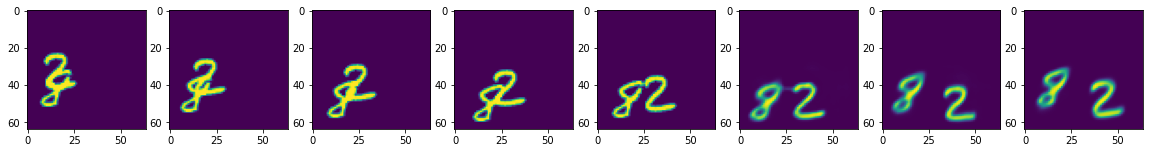

[06] mse loss: 0.00467 | kld loss: 1.33882 (691200)


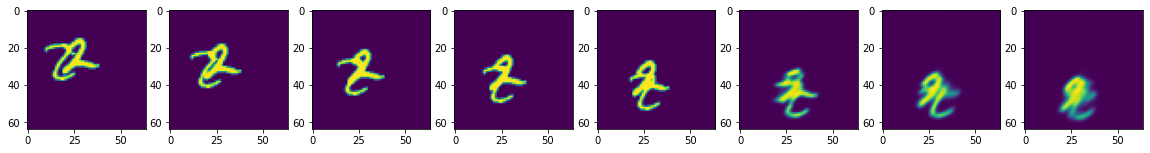

[06] mse loss: 0.00522 | kld loss: 1.50358 (691200)



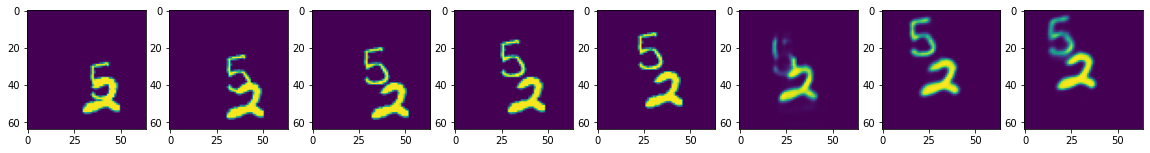

[07] mse loss: 0.00054 | kld loss: 0.16432 (806400)


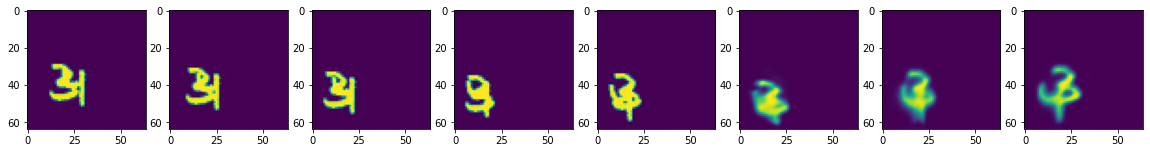

[07] mse loss: 0.00106 | kld loss: 0.32713 (806400)


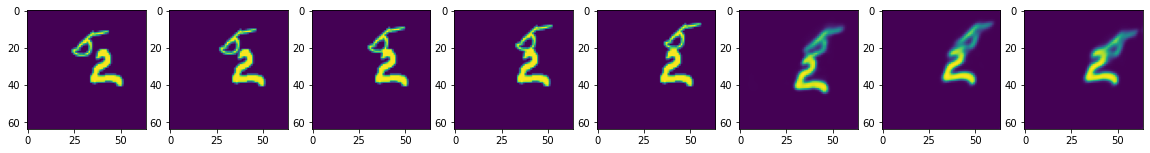

[07] mse loss: 0.00159 | kld loss: 0.49024 (806400)


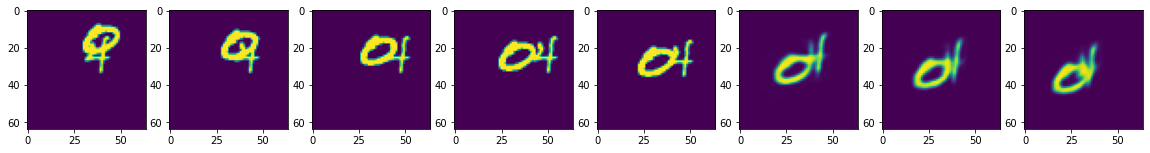

[07] mse loss: 0.00211 | kld loss: 0.65221 (806400)


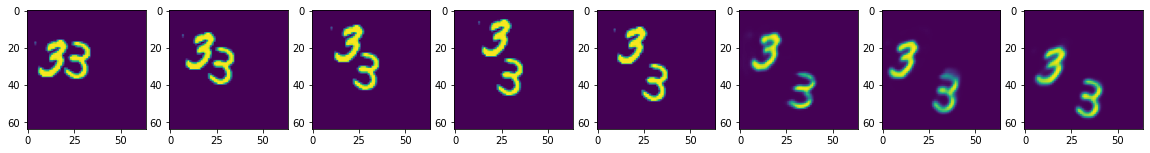

[07] mse loss: 0.00262 | kld loss: 0.81121 (806400)


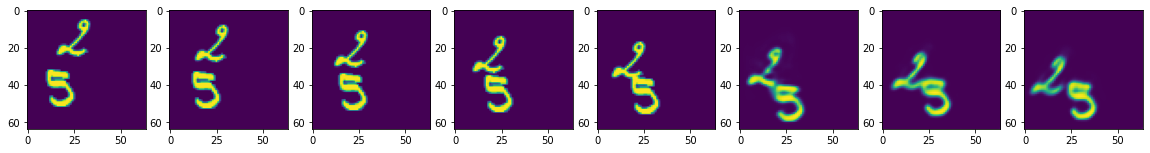

[07] mse loss: 0.00314 | kld loss: 0.97517 (806400)


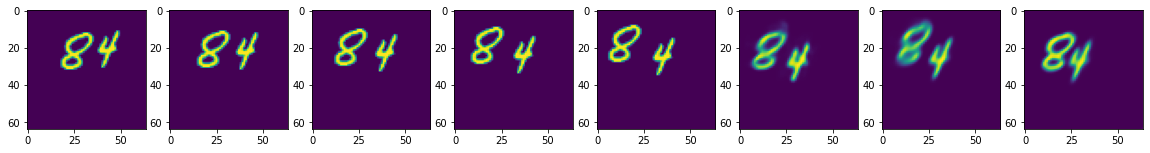

[07] mse loss: 0.00365 | kld loss: 1.13367 (806400)


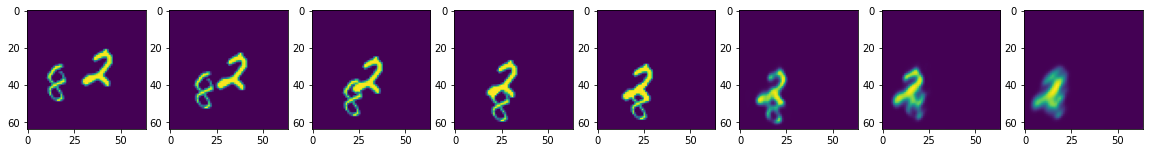

[07] mse loss: 0.00415 | kld loss: 1.29425 (806400)


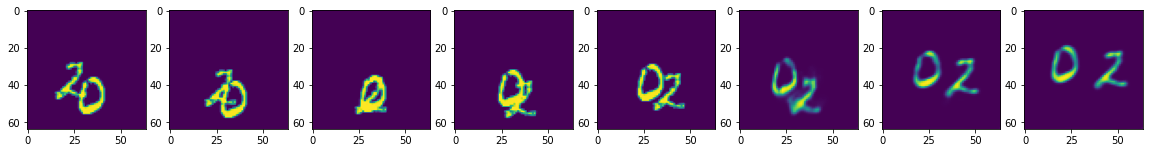

[07] mse loss: 0.00466 | kld loss: 1.45487 (806400)



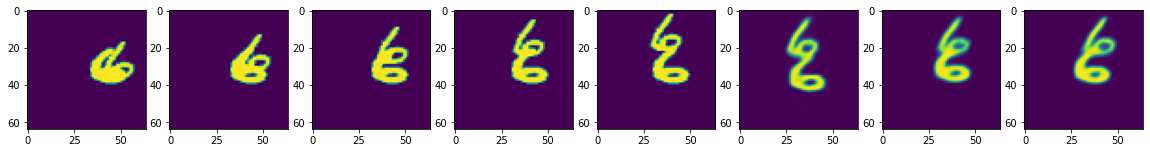

[08] mse loss: 0.00050 | kld loss: 0.16070 (921600)


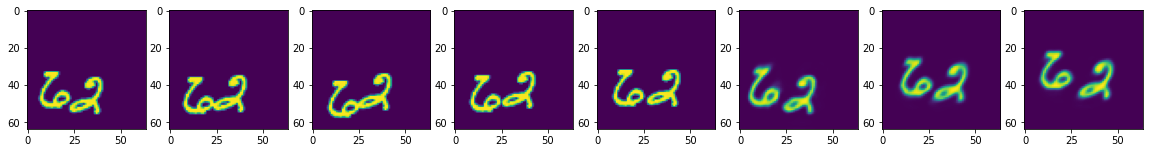

[08] mse loss: 0.00100 | kld loss: 0.32065 (921600)


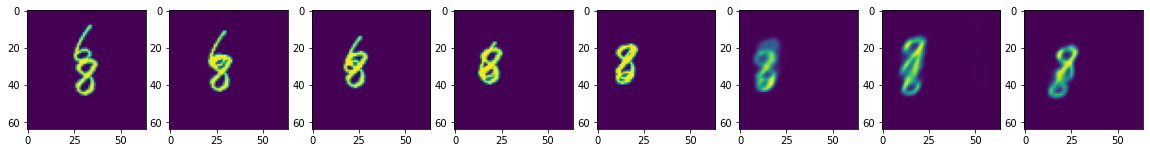

[08] mse loss: 0.00149 | kld loss: 0.48098 (921600)


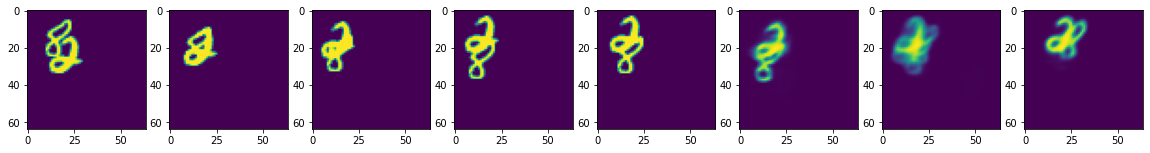

[08] mse loss: 0.00198 | kld loss: 0.63787 (921600)


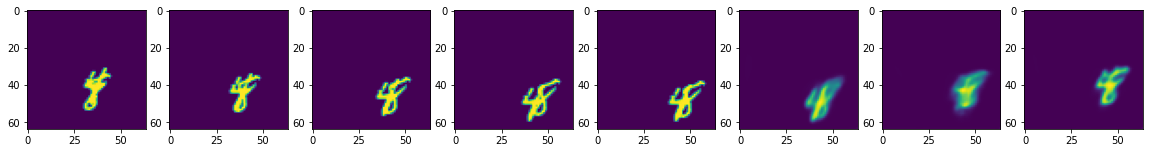

[08] mse loss: 0.00248 | kld loss: 0.79649 (921600)


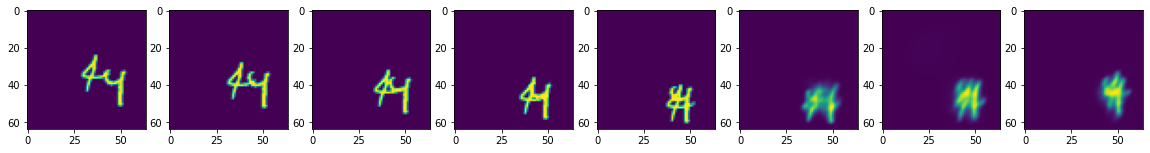

[08] mse loss: 0.00298 | kld loss: 0.95430 (921600)


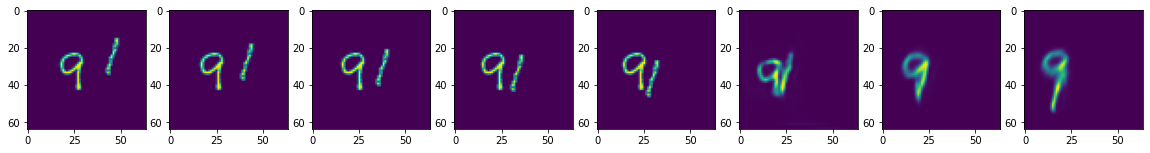

[08] mse loss: 0.00347 | kld loss: 1.11398 (921600)


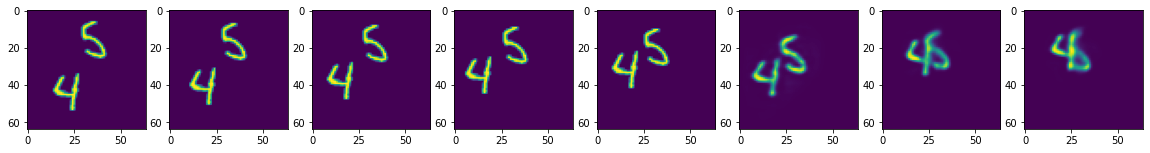

[08] mse loss: 0.00396 | kld loss: 1.26831 (921600)


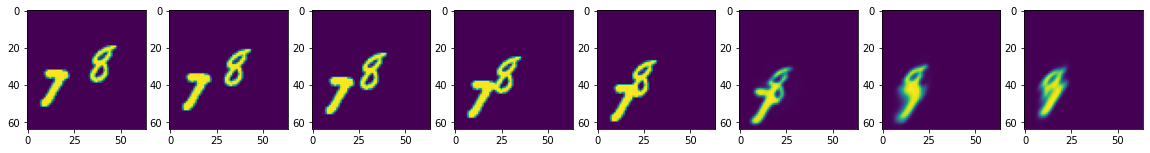

[08] mse loss: 0.00445 | kld loss: 1.42312 (921600)



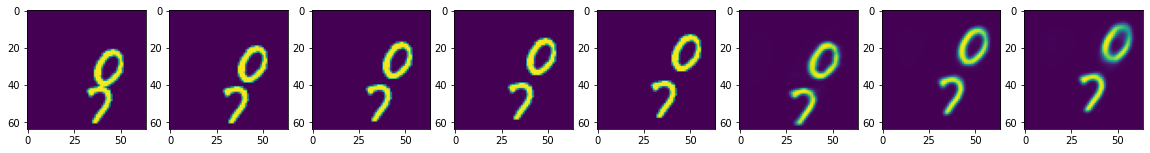

[09] mse loss: 0.00048 | kld loss: 0.15363 (1036800)


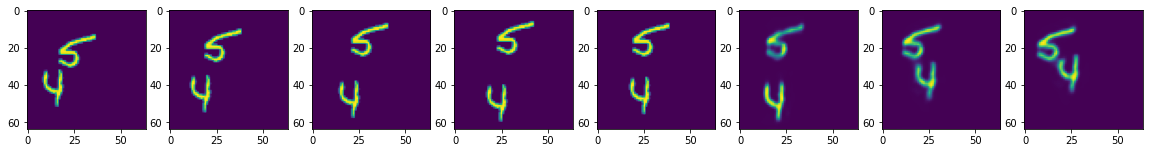

[09] mse loss: 0.00096 | kld loss: 0.30844 (1036800)


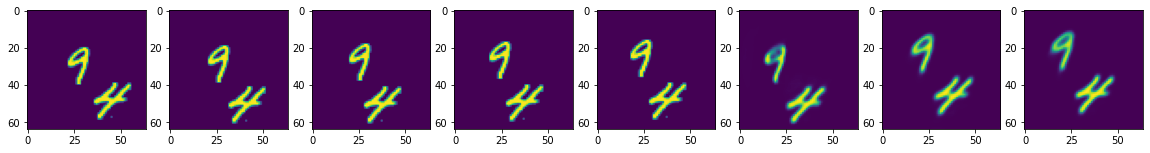

[09] mse loss: 0.00144 | kld loss: 0.46526 (1036800)


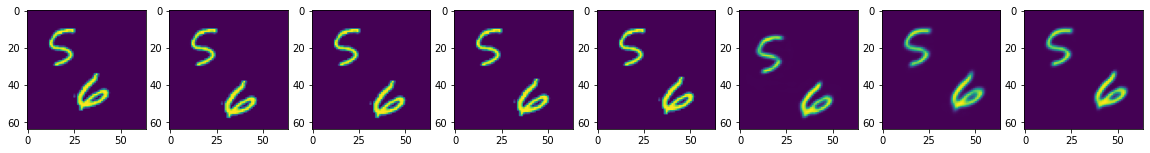

[09] mse loss: 0.00192 | kld loss: 0.61948 (1036800)


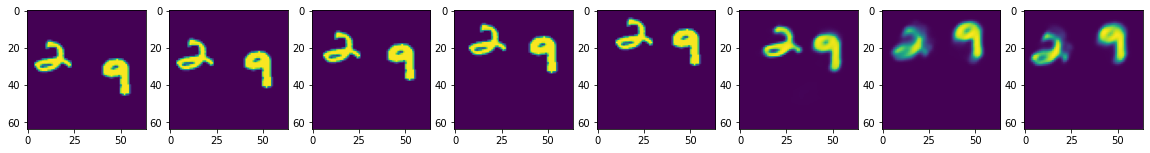

[09] mse loss: 0.00239 | kld loss: 0.77520 (1036800)


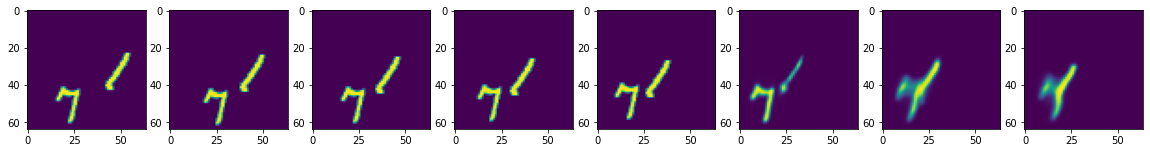

[09] mse loss: 0.00287 | kld loss: 0.93079 (1036800)


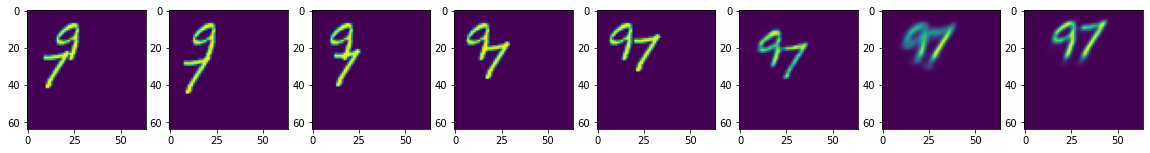

[09] mse loss: 0.00333 | kld loss: 1.08874 (1036800)


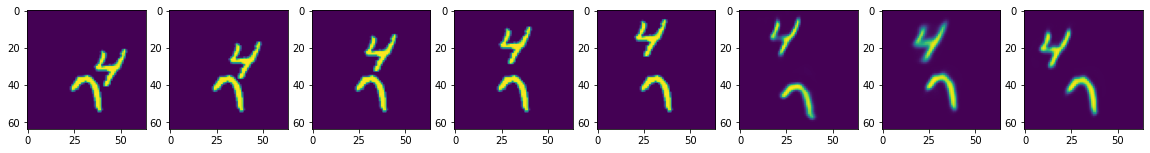

[09] mse loss: 0.00380 | kld loss: 1.24581 (1036800)


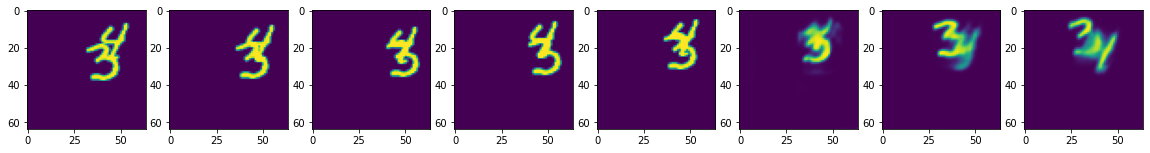

[09] mse loss: 0.00426 | kld loss: 1.40110 (1036800)



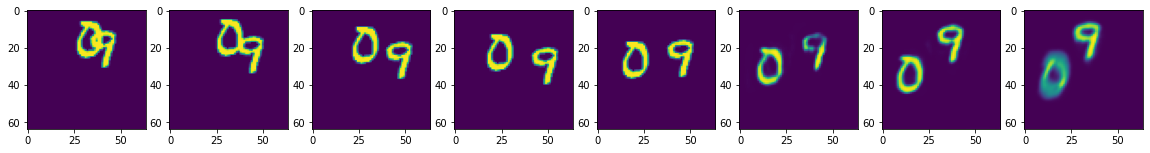

[10] mse loss: 0.00047 | kld loss: 0.15265 (1152000)


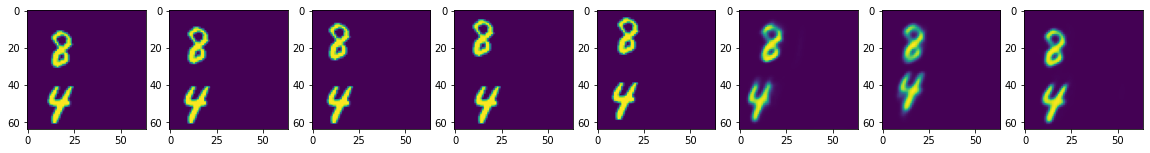

[10] mse loss: 0.00093 | kld loss: 0.30777 (1152000)


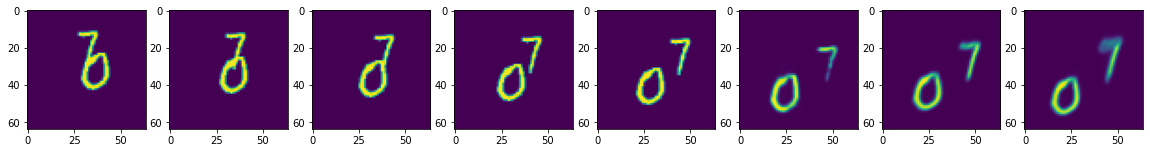

[10] mse loss: 0.00139 | kld loss: 0.46350 (1152000)


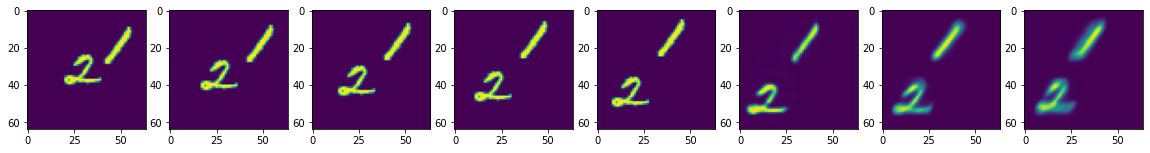

[10] mse loss: 0.00186 | kld loss: 0.61710 (1152000)


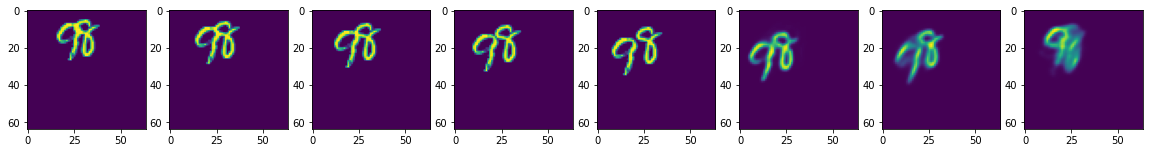

[10] mse loss: 0.00231 | kld loss: 0.77169 (1152000)


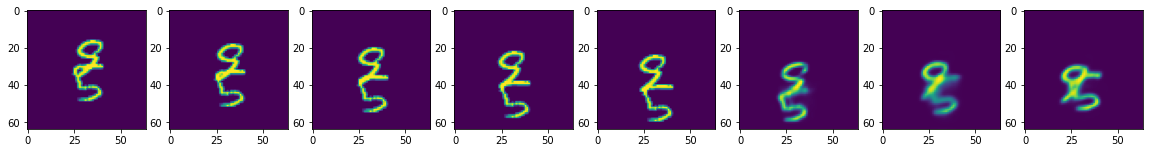

[10] mse loss: 0.00278 | kld loss: 0.92461 (1152000)


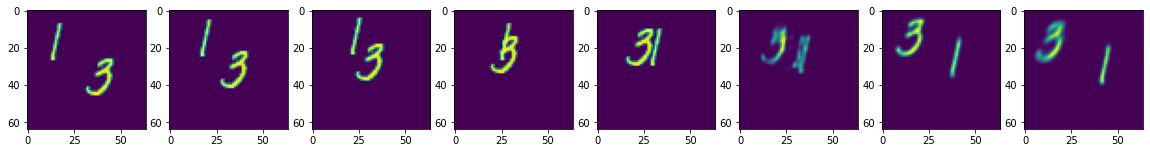

[10] mse loss: 0.00324 | kld loss: 1.07630 (1152000)


KeyboardInterrupt: ignored

In [6]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

z_dim=10
g_dim = 128 # dimensions of encoder output vector and decoder input vector
rnn_size = 256 # hidden layer dim
posterior_rnn_layers = 1
predictor_rnn_layers = 2
prior_rnn_layers = 1
epoch_size = 600
niter = 300
channels = 1
n_past = 5 # number of frames to condition on
last_frame_skip = True
n_future = 3 #number of frames to predict


encoder = Encoder(g_dim, channels)
decoder = Decoder(g_dim, channels)
encoder.apply(init_weights)
decoder.apply(init_weights)
mse_criterion = nn.MSELoss()
frame_predictor = lstm_svg(g_dim+z_dim, g_dim, rnn_size, predictor_rnn_layers, batch_size)
posterior = gaussian_lstm(g_dim, z_dim, rnn_size, posterior_rnn_layers, batch_size)
prior = gaussian_lstm(g_dim, z_dim, rnn_size, prior_rnn_layers, batch_size)
frame_predictor.apply(init_weights)
posterior.apply(init_weights)
prior.apply(init_weights)



learning_rate = 0.002
c_optimizer = torch.optim.Adam
frame_predictor_optimizer = c_optimizer(frame_predictor.parameters(), lr=learning_rate, betas=(0.9, 0.999))
posterior_optimizer = c_optimizer(posterior.parameters(), lr=learning_rate, betas=(0.9, 0.999))
prior_optimizer = c_optimizer(prior.parameters(), lr=learning_rate, betas=(0.9, 0.999))
encoder_optimizer = c_optimizer(encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
decoder_optimizer = c_optimizer(decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))


frame_predictor.cuda()
posterior.cuda()
prior.cuda()
encoder.cuda()
decoder.cuda()
mse_criterion.cuda()

def model(x):
  frame_predictor.zero_grad()
  posterior.zero_grad()
  prior.zero_grad()
  encoder.zero_grad()
  decoder.zero_grad()
  
  frame_predictor.hidden = frame_predictor.init_hidden()
  posterior.hidden = posterior.init_hidden()
  prior.hidden = prior.init_hidden()

  mse = 0
  kld = 0
  beta = 0.0001

  for i in range(1, n_past+n_future):
      h = encoder(x[:,i-1,:,:,:])
      h_target = encoder(x[:,i,:,:,:])[0]

      if last_frame_skip or i < n_past:	
          h, skip = h
      else:
          h = h[0]
      z_t, mu, logvar = posterior(h_target)
      _, mu_p, logvar_p = prior(h)
      h_pred = frame_predictor(torch.cat([h, z_t], 1))
      x_pred = decoder([h_pred, skip])
      mse += mse_criterion(x_pred, x[:,i,:,:,:])
      dist_enc = td.Normal(mu, torch.exp(logvar))
      dist_prior = td.Normal(mu_p, torch.exp(logvar_p))
      kld += (td.kl_divergence(dist_enc, dist_prior).sum() / batch_size)
  
  loss = mse + kld*beta
  loss.backward()

  frame_predictor_optimizer.step()
  posterior_optimizer.step()
  prior_optimizer.step()
  encoder_optimizer.step()
  decoder_optimizer.step()
  return mse.data.cpu().numpy()/(n_past+n_future), kld.data.cpu().numpy()/(n_future+n_past)

def convert_to_numpy(x):
        return x[0,:,:,:].permute(1,2,0).squeeze().detach().cpu().numpy()

def plot_rec(x):
    frame_predictor.hidden = frame_predictor.init_hidden()
    posterior.hidden = posterior.init_hidden()
    gen_seq = []
    gen_seq.append(x[:, 0,:,:,:])
    x_in = x[:,0,:,:,:]
    for i in range(1, n_past + n_future):
        h = encoder(x[:,i-1,:,:,:])
        h_target = encoder(x[:,i,:,:,:])[0]
        if last_frame_skip or i < n_past:	
            h, skip = h
        else:
            h, _ = h
        h = h.detach()
        h_target = h_target.detach()
        #z_t, _, _= posterior(h_target)
        z_t, _, _ = prior(h)
        if i < n_past:
            gen_seq.append(x[:,i,:,:,:])
        else:
            h_pred = frame_predictor(torch.cat([h, z_t], 1))
            x_pred = decoder([h_pred, skip]).detach()
            #mean, logvar = decoder([h_pred, skip])
            #mean = mean.detach()
            #std = torch.exp(logvar.detach())
            gen_seq.append(x_pred)
    
    fig, ax = plt.subplots(1, len(gen_seq) , figsize = (20,5))
    for i in range(len(gen_seq)):
      ax[i].imshow(convert_to_numpy(gen_seq[i]))
    plt.show()

kl_loss = []
mse_loss = []
for epoch in range(niter):
    frame_predictor.train()
    posterior.train()
    prior.train()
    encoder.train()
    decoder.train()
    epoch_mse = 0
    epoch_kld = 0
    for batch_i, x in enumerate(tqdm(train_loader)):
        # train frame_predictor 
        mse, kld = model(x.to(device))
        epoch_mse += mse
        epoch_kld += kld
        kl_loss.append(kld.data)
        mse_loss.append(mse.data)
        if (batch_i+1) % 100 == 0:
          x_test = next(iter(test_loader)).to(device)
          # plot some stuff
          frame_predictor.eval()
          encoder.eval()
          decoder.eval()
          posterior.eval()
          prior.eval()
          plot_rec(x_test)
          print('[%02d] mse loss: %.5f | kld loss: %.5f (%d)' % (epoch, epoch_mse/1800, epoch_kld/1800, epoch*1800*batch_size))
          frame_predictor.train()
          posterior.train()
          prior.train()
          encoder.train()
          decoder.train()
    # plot some stuff
#https://github.com/edenton/svg/blob/master/train_svg_lp.py


